# Week 1: Structural Code Extraction
## Building the Foundation Graph

In this notebook, we'll:
1. Parse a Python codebase using AST
2. Build a knowledge graph
3. Explore graph properties
4. Visualize the graph
5. Query relationships

In [37]:
%pwd

'd:\\kaggle_project\\GraphRAG\\notebooks'

In [7]:
sys.path.insert(0, '../src')

In [21]:
# Setup
import sys
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Add src to path
sys.path.insert(0, '../src')

from indexing.ast_parser import ASTParser
from indexing.graph_builder import GraphBuilder, visualize_graph

# Configure plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Create Sample Repository

In [ ]:
# Create sample repo if it doesn't exist
import os
sys.path.insert(0, '../scripts')
from create_sample_repo import create_sample_repo

repo_path = '../data/sample_repos/simple_python'
if not os.path.exists(repo_path):
    create_sample_repo(repo_path)
    print(f"✓ Sample repository created")
else:
    print(f"✓ Using existing repository")

In [7]:
repo_path = 'd:/kaggle_project/GraphRAG/data/repositories/SMS-Spam-VotingClassifier-'

## 2. Parse Code Repository

In [8]:
# Initialize parser
parser = ASTParser(repo_path, languages=['python'])

# Parse repository
entities = parser.parse_repository()

print(f"Extracted {len(entities)} code entities\n")

# Show entity type breakdown
entity_counts = Counter(e.type for e in entities)
print("Entity Types:")
for entity_type, count in entity_counts.most_common():
    print(f"  {entity_type}: {count}")

2025-12-15 15:09:02.072 | INFO     | indexing.ast_parser:_setup_parsers:144 - Initialized parsers for: ['python']
2025-12-15 15:09:02.081 | INFO     | indexing.ast_parser:parse_repository:167 - Found 3 python files
2025-12-15 15:09:02.088 | INFO     | indexing.ast_parser:parse_repository:176 - Extracted 25 code entities


name_node: <Node type=identifier, start_point=(16, 4), end_point=(16, 25)>
name_node: <Node type=identifier, start_point=(38, 4), end_point=(38, 19)>
name_node: <Node type=identifier, start_point=(11, 4), end_point=(11, 18)>
name_node: <Node type=identifier, start_point=(13, 4), end_point=(13, 21)>
name_node: <Node type=identifier, start_point=(44, 4), end_point=(44, 21)>
Extracted 25 code entities

Entity Types:
  import: 20
  function: 5


In [9]:
# Examine a few entities
print("Sample Entities:\n")

for i, entity in enumerate(entities[:5]):
    print(f"{i+1}. {entity.type.upper()}: {entity.name}")
    print(f"   File: {Path(entity.file_path).name}")
    print(f"   Lines: {entity.start_line}-{entity.end_line}")
    if entity.docstring:
        print(f"   Doc: {entity.docstring[:60]}...")
    print()

Sample Entities:

1. IMPORT: os
   File: file.py
   Lines: 1-1

2. IMPORT: psycopg2
   File: file.py
   Lines: 2-2

3. IMPORT: fastapi
   File: file.py
   Lines: 3-3

4. IMPORT: utils.db_connection
   File: file.py
   Lines: 4-4

5. IMPORT: utils.security
   File: file.py
   Lines: 5-5



## 3. Build Knowledge Graph

In [10]:
# Build graph
builder = GraphBuilder()
graph = builder.build_graph(entities)

print(f"Graph constructed:")
print(f"  Nodes: {graph.number_of_nodes()}")
print(f"  Edges: {graph.number_of_edges()}")

2025-12-15 15:09:09.463 | INFO     | indexing.graph_builder:build_graph:44 - Building graph from 25 entities
2025-12-15 15:09:09.464 | INFO     | indexing.graph_builder:_add_nodes:82 - Added 25 nodes
2025-12-15 15:09:09.466 | INFO     | indexing.graph_builder:_add_import_edges:112 - Added import edges
2025-12-15 15:09:09.468 | INFO     | indexing.graph_builder:_add_call_edges:137 - Added call edges
2025-12-15 15:09:09.469 | INFO     | indexing.graph_builder:build_graph:55 - Graph built: 28 nodes, 209 edges


Graph constructed:
  Nodes: 28
  Edges: 209


In [7]:
# Get detailed statistics
stats = builder.get_graph_stats()

print("\n=== Graph Statistics ===")
print(f"Density: {stats['density']:.4f}")
print(f"Weakly Connected: {stats['is_connected']}")

print("\n=== Node Types ===")
for node_type, count in sorted(stats['node_types'].items()):
    print(f"{node_type}: {count}")

print("\n=== Edge Types ===")
for edge_type, count in sorted(stats['edge_types'].items()):
    print(f"{edge_type}: {count}")


=== Graph Statistics ===
Density: 0.2765
Weakly Connected: False

=== Node Types ===
file: 3
function: 5
import: 20

=== Edge Types ===
CALLS: 2
CONTAINS: 25
IMPORTS: 182


## 4. Explore Graph Structure

In [11]:
# Find most connected nodes (highest degree)
degree_dict = dict(graph.degree())
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Most Connected Nodes:")
for node_id, degree in top_nodes:
    node_data = graph.nodes[node_id]
    print(f"  {node_data['name']} ({node_data['type']}): {degree} connections")

Most Connected Nodes:
  dotenv (import): 29 connections
  psycopg2 (import): 24 connections
  fastapi (import): 24 connections
  utils.db_connection (import): 24 connections
  utils.security (import): 24 connections
  typing (import): 24 connections
  minio (import): 24 connections
  utils.minio_services (import): 24 connections
  utils.minio_helper (import): 24 connections
  datetime (import): 24 connections


In [12]:
# Analyze a specific function
def explore_function(function_name):
    """Explore a function's relationships"""
    
    # Find function node
    func_node = None
    for node_id, attrs in graph.nodes(data=True):
        if attrs.get('name') == function_name and attrs.get('type') == 'function':
            func_node = node_id
            break
    
    if not func_node:
        print(f"Function '{function_name}' not found")
        return
    
    print(f"Function: {function_name}")
    print(f"Node ID: {func_node}\n")
    
    # Get predecessors (who calls this?)
    predecessors = list(graph.predecessors(func_node))
    print(f"Called by ({len(predecessors)}):")
    for pred in predecessors:
        pred_data = graph.nodes[pred]
        edge_data = graph[pred][func_node]
        print(f"  - {pred_data['name']} (via {edge_data['type']})")
    
    # Get successors (what does this call?)
    successors = list(graph.successors(func_node))
    print(f"\nCalls ({len(successors)}):")
    for succ in successors:
        succ_data = graph.nodes[succ]
        edge_data = graph[func_node][succ]
        print(f"  - {succ_data['name']} (via {edge_data['type']})")

# Try exploring the main function
explore_function('create_connection')

Function: create_connection
Node ID: function:d:\kaggle_project\GraphRAG\data\repositories\SMS-Spam-VotingClassifier-\src\utils\db_connection.py:create_connection:14

Called by (3):
  - fetch_hashed_password (via CALLS)
  - fetch_user_data (via CALLS)
  - d:\kaggle_project\GraphRAG\data\repositories\SMS-Spam-VotingClassifier-\src\utils\db_connection.py (via CONTAINS)

Calls (2):
  - psycopg2.pool (via IMPORTS)
  - dotenv (via IMPORTS)


In [13]:
# Find shortest path between two functions
def find_path(source_name, target_name):
    """Find shortest path between two functions"""
    
    # Find nodes
    source_node = None
    target_node = None
    
    for node_id, attrs in graph.nodes(data=True):
        if attrs.get('name') == source_name:
            source_node = node_id
        if attrs.get('name') == target_name:
            target_node = node_id
    
    if not source_node or not target_node:
        print("Function(s) not found")
        return
    
    try:
        path = nx.shortest_path(graph, source_node, target_node)
        print(f"Path from {source_name} to {target_name}:")
        for i, node in enumerate(path):
            node_data = graph.nodes[node]
            print(f"  {i+1}. {node_data['name']} ({node_data['type']})")
            if i < len(path) - 1:
                edge = graph[node][path[i+1]]
                print(f"      └─ {edge['type']} →")
    except nx.NetworkXNoPath:
        print(f"No path found between {source_name} and {target_name}")

find_path('fetch_user_data', 'db_connection')

Function(s) not found


## 5. Visualize Graph

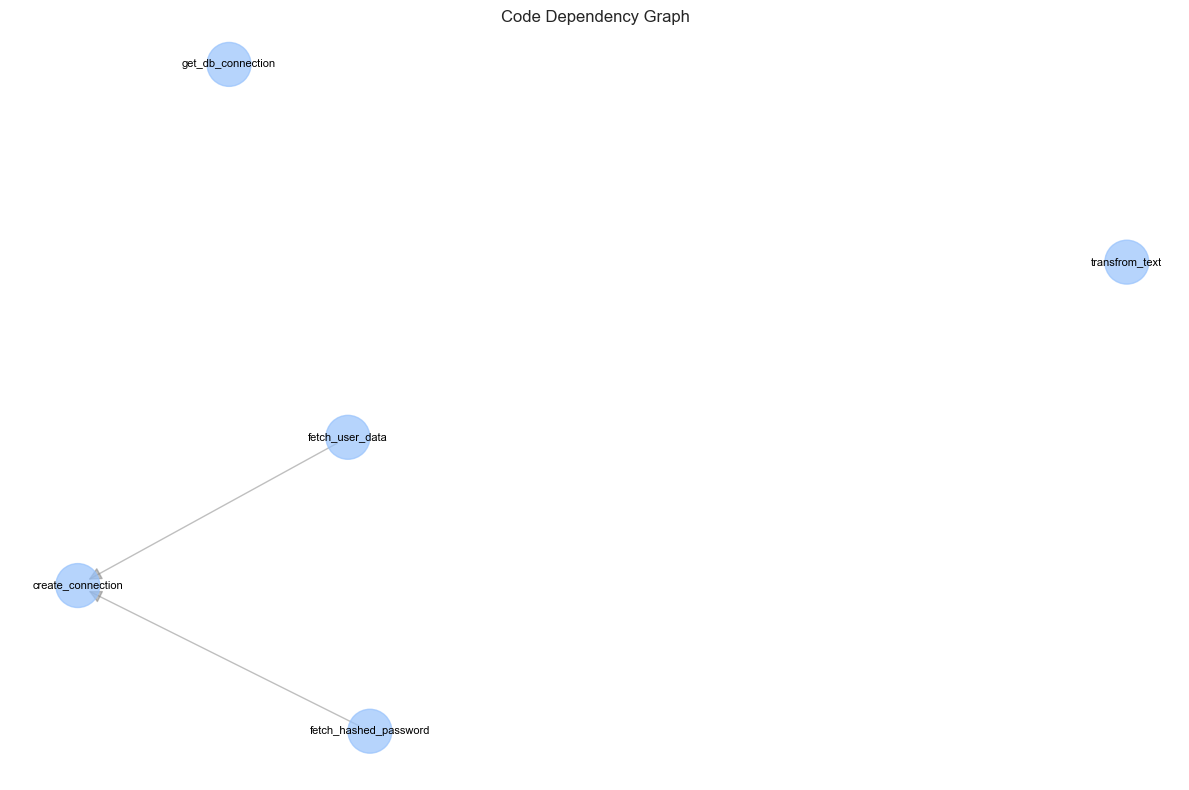

In [18]:
# Simple matplotlib visualization (for small graphs)
def plot_graph_simple(g, max_nodes=30):
    """Create simple matplotlib visualization"""
    
    # Filter to function nodes only for clarity
    func_nodes = [n for n, attrs in g.nodes(data=True) 
                  if attrs.get('type') in ['function', 'class']]
    
    if len(func_nodes) > max_nodes:
        func_nodes = func_nodes[:max_nodes]
    
    subgraph = g.subgraph(func_nodes)
    
    plt.figure(figsize=(12, 8))
    
    # Layout
    pos = nx.spring_layout(subgraph, k=1, iterations=50)
    
    # Draw nodes
    node_colors = ['#97C2FC' if subgraph.nodes[n].get('type') == 'function' 
                   else '#FB7E81' for n in subgraph.nodes()]
    
    nx.draw_networkx_nodes(subgraph, pos, 
                          node_color=node_colors,
                          node_size=1000,
                          alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, 
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20,
                          alpha=0.5)
    
    # Draw labels
    labels = {n: subgraph.nodes[n]['name'] for n in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)
    
    plt.title("Code Dependency Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_graph_simple(graph)

In [22]:
# Create interactive HTML visualization
visualize_graph(graph, '../data/outputs/interactive_graph.html')
print("✓ Interactive visualization saved to: data/outputs/interactive_graph.html")
print("  Open this file in your browser for full interactivity!")

../data/outputs/interactive_graph.html


AttributeError: 'NoneType' object has no attribute 'render'

## 6. Save Graph

In [ ]:
# Save graph for later use
output_path = '../data/graphs/week1_graph.pkl'
builder.save_graph(output_path)
print(f"✓ Graph saved to {output_path}")

## Next Steps

Week 1 Complete! You now have:
- ✓ Code parsing working
- ✓ Knowledge graph built
- ✓ Graph visualization
- ✓ Basic graph queries

**Week 2 Preview:**
- Add semantic enrichment (LLM-generated summaries)
- Create vector embeddings
- Build FAISS index for similarity search